In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from matplotlib.pyplot import subplots
import joblib

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [2]:
root_dir = 'train/'
csv_file = 'labels.csv'

In [3]:
#Hyperparameters
TRAIN_SIZE = 0.8
TEST_SIZE = 0.2
BATCH_SIZE = 64

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.data = csv_file
        self.root_dir = root_dir
        self.transform = transform
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.loc[idx, "id"] + ".jpg")
        image = Image.open(img_name)
        label_int = torch.tensor(self.data.loc[idx, "breed"], dtype=torch.long)
        # one_hot_label = torch.zeros(self.num_classes)
        # one_hot_label[label_int] = 1
        if self.transform:
            image = self.transform(image)
        return image, label_int

labels_df = pd.read_csv(csv_file)
num_classes = labels_df['breed'].nunique()

# Create a label encoder object
le = LabelEncoder()

# Fit and transform the 'breed' column to get integer labels
labels_df['breed'] = le.fit_transform(labels_df['breed'])
joblib.dump(le, 'label_encoder.pkl')

#Data Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Imagenet normalization
])

#Datasets
dataset = CustomImageDataset(root_dir=root_dir, csv_file=labels_df, transform=transform)
total_samples = len(dataset)
train_size = TRAIN_SIZE
test_size = TEST_SIZE
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [5]:
labels_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,19
1,001513dfcb2ffafc82cccf4d8bbaba97,37
2,001cdf01b096e06d78e9e5112d419397,85
3,00214f311d5d2247d5dfe4fe24b2303d,15
4,0021f9ceb3235effd7fcde7f7538ed62,49


In [6]:
#Resnet
model = torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, num_classes)

#Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

#Using CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

C:\Users\elmow\Documents\Kaggle\Dog_Classification\dbcl_main\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\elmow\Documents\Kaggle\Dog_Classification\dbcl_main\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
#Trainning Loop
num_epochs = 10
errors_list = []
for epoch in range(num_epochs):
    
    model.train()
    running_train_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss_val = criterion(outputs, labels)
        loss_val.backward()
        optimizer.step()

        running_train_loss += loss_val.item()

    model.eval()
    running_test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss_val = criterion(outputs, labels)
            
            running_test_loss += loss_val.item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_test_loss = running_test_loss / len(test_loader)
    
    errors_list.append({'test_loss': avg_test_loss, 'train_loss': avg_train_loss})

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_train_loss}, Test_Loss: {avg_test_loss}")

Epoch 1/10, Loss: 4.316491685807705, Test_Loss: 3.5230277106165886
Epoch 2/10, Loss: 2.9105074871331453, Test_Loss: 2.4518818855285645
Epoch 3/10, Loss: 2.0445319768041372, Test_Loss: 1.8564185127615929
Epoch 4/10, Loss: 1.5461990274488926, Test_Loss: 1.540562268346548
Epoch 5/10, Loss: 1.2384138363413513, Test_Loss: 1.3471577055752277
Epoch 6/10, Loss: 1.02432756498456, Test_Loss: 1.2382279224693775
Epoch 7/10, Loss: 0.8655949551612139, Test_Loss: 1.1596639901399612
Epoch 8/10, Loss: 0.7338943057693541, Test_Loss: 1.0999422185122967
Epoch 9/10, Loss: 0.6272458999883384, Test_Loss: 1.0566688440740108
Epoch 10/10, Loss: 0.5367637544404715, Test_Loss: 1.0297250058501959


In [8]:
errors = pd.DataFrame(errors_list)
errors

,test_loss,train_loss
0,3.523028,4.316492
1,2.451882,2.910507
2,1.856419,2.044532
3,1.540562,1.546199
4,1.347158,1.238414
5,1.238228,1.024328
6,1.159664,0.865595
7,1.099942,0.733894
8,1.056669,0.627246
9,1.029725,0.536764


Text(0, 0.5, 'Loss')

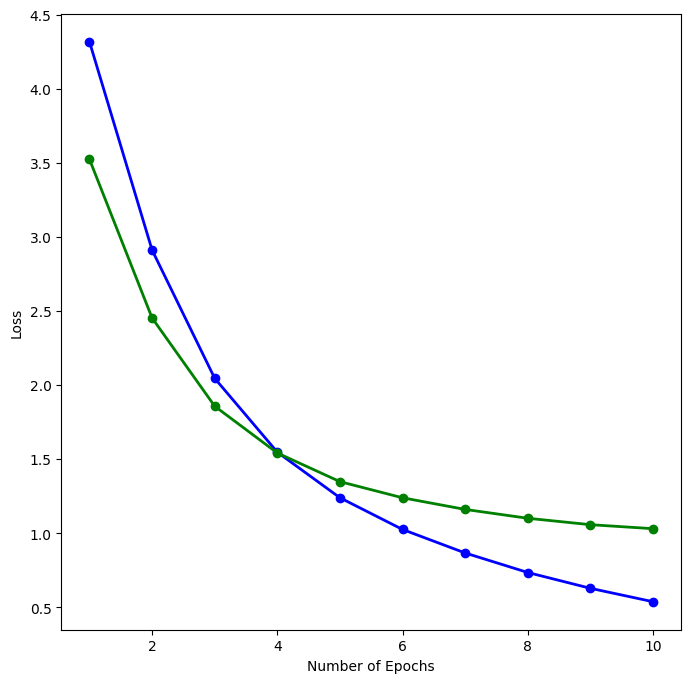

In [9]:
fig, ax = subplots(figsize=(8,8))
ax.plot([i + 1 for i in range(errors.shape[0])],errors['train_loss'], color='blue', marker='o', linewidth=2)
ax.plot([i + 1 for i in range(errors.shape[0])],errors['test_loss'], color='green', marker='o', linewidth=2)
ax.set_xlabel("Number of Epochs")
ax.set_ylabel("Loss")



In [10]:
torch.save(model.state_dict(), 'saved_param/ResNet.pth')

In [11]:
model.load_state_dict(torch.load('saved_param/ResNet.pth'))
model.eval();

In [12]:
le = joblib.load

In [13]:
def predict(model, input):
    with torch.no_grad():
        output = model(input)
        probabilities = torch.nn.functional.softmax(output, dim=1)
    return probabilities

In [14]:
labels_df['breed'].unique()
le = joblib.load('label_encoder.pkl')
classes = le.inverse_transform(labels_df['breed'].unique())

In [15]:
image, label = dataset[0]
image = image.unsqueeze(0)
image = image.to(device)

In [54]:
submission = pd.DataFrame()

for root, dirs, files in os.walk("test"):
    for filename in files:
        image_path = os.path.join('test/', filename)
        image = Image.open(image_path)
        image = transform(image)
        image = image.unsqueeze(0)
        image = image.to(device)
        prediction = predict(model, image).squeeze()
        img_data = {'id': filename[:-4]}
        
        for i in range(len(prediction)):
            img_data[classes[i]] = prediction[i].item()
        submission_data.append(dict_list)
        img_df = pd.DataFrame([img_data])
        submission = pd.concat([submission, img_df], ignore_index=True)



In [55]:
submission.head()

,id,boston_bull,dingo,pekinese,bluetick,golden_retriever,bedlington_terrier,borzoi,basenji,scottish_deerhound,...,blenheim_spaniel,silky_terrier,sussex_spaniel,german_short-haired_pointer,french_bulldog,bouvier_des_flandres,tibetan_mastiff,english_springer,cocker_spaniel,rottweiler
0,000621fb3cbb32d8935728e48679680e,0.001284,0.001721,0.000198,0.000058,0.000209,0.001235,0.000243,0.000309,0.000835,...,0.000266,0.001499,0.000121,0.000438,0.000060,0.001357,0.000464,0.000318,0.000225,0.000469
1,00102ee9d8eb90812350685311fe5890,0.000039,0.000018,0.000043,0.000004,0.000049,0.000061,0.000026,0.000049,0.000004,...,0.000111,0.000094,0.000007,0.000063,0.000027,0.000022,0.000965,0.000018,0.000057,0.000008
2,0012a730dfa437f5f3613fb75efcd4ce,0.000007,0.001734,0.000025,0.000041,0.000032,0.000014,0.000051,0.000005,0.002028,...,0.000058,0.000006,0.000204,0.000517,0.000809,0.012182,0.000043,0.000139,0.000049,0.000023
3,001510bc8570bbeee98c8d80c8a95ec1,0.008100,0.002763,0.001872,0.000514,0.014185,0.000934,0.000377,0.000497,0.001552,...,0.001016,0.000170,0.004698,0.000935,0.008065,0.000376,0.000214,0.003682,0.000177,0.000785
4,001a5f3114548acdefa3d4da05474c2e,0.079029,0.001369,0.000165,0.000149,0.000152,0.000183,0.001482,0.000077,0.000181,...,0.002808,0.000131,0.000094,0.000230,0.000078,0.000118,0.001024,0.000195,0.000729,0.006105


In [59]:
submission.to_csv('submissionResNet.csv', index=False)